In [1]:
from fish_helpers import *
from analysis_scripts.onfly_decon_codestacks import *
from segmentation_3D import *

In [2]:
md_path = '/hybedata/Images/Michelle/FISH_Signal_Amp/18_bit_PER_2019Aug07/'
md = Metadata(md_path)

In [4]:
pos = md.image_table.Position.unique()[25]
acq = [i for i in md.image_table.acq.unique() if 'hybe' in i][1]
z = 10
color = 'FarRed'
print('pos: ',pos,' z:',z,' acq:',acq)

pos:  2-Pos_004_002  z: 10  acq: hybe1_1


In [5]:
img = md.stkread(Position=pos,Channel=color,acq=acq,Zindex=z)[:,:,0]

opening img_2-Pos_004_002_000000010_000000000_FarRed_000_010.tif

<IPython.core.display.Javascript object>


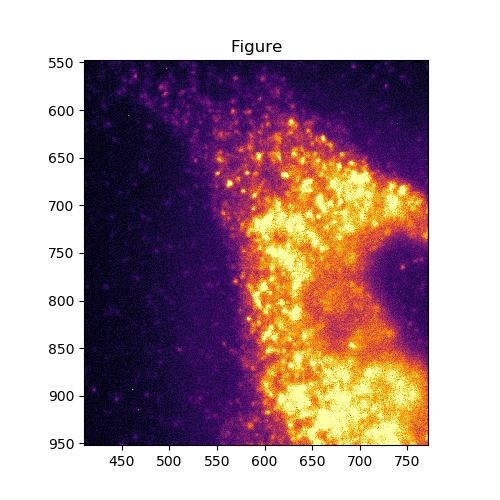

In [6]:
%matplotlib notebook
Display(img,figsize=[5,5])

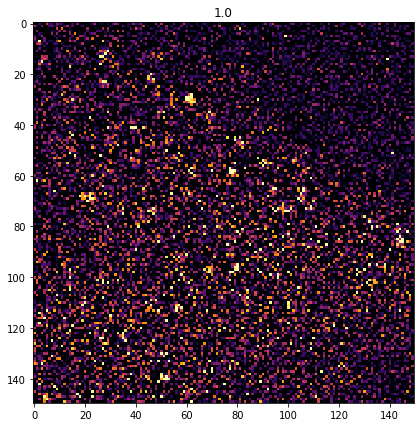

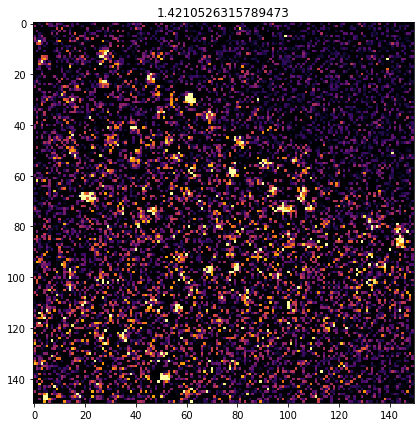

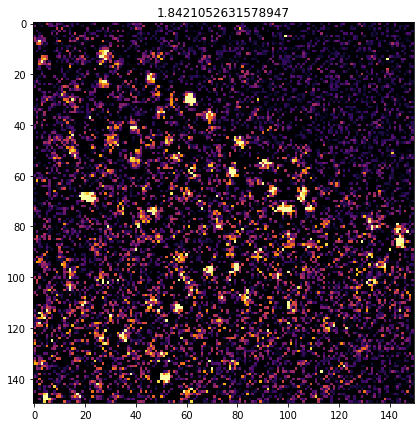

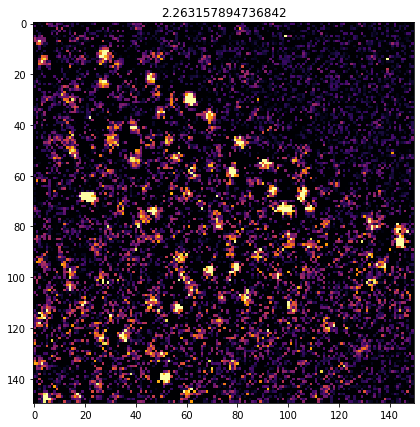

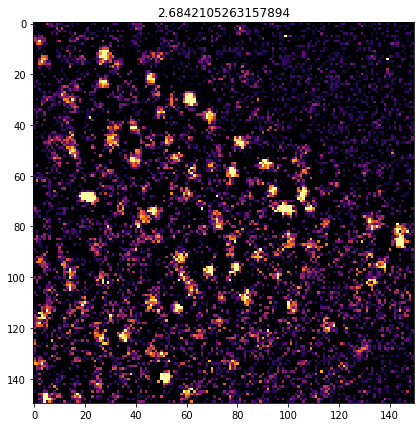

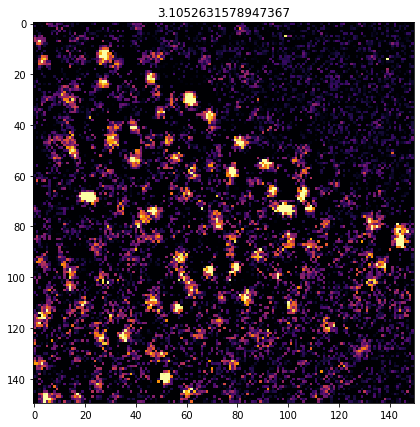

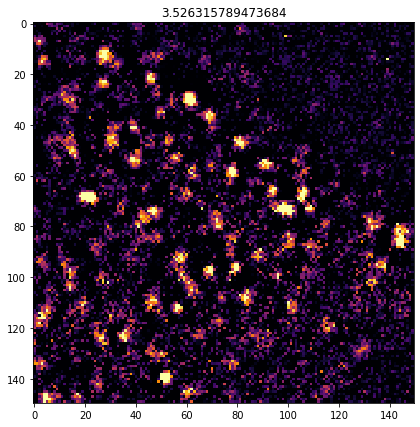

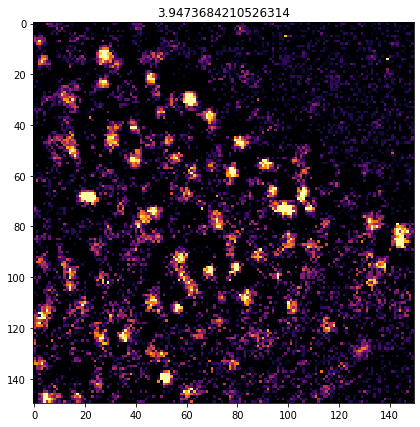

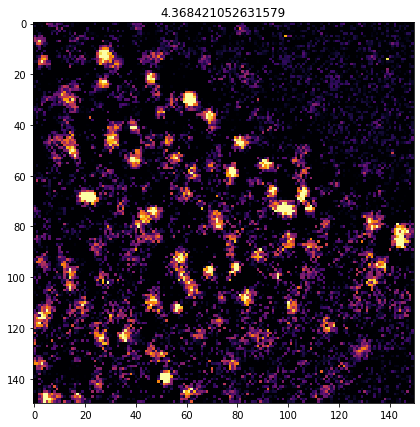

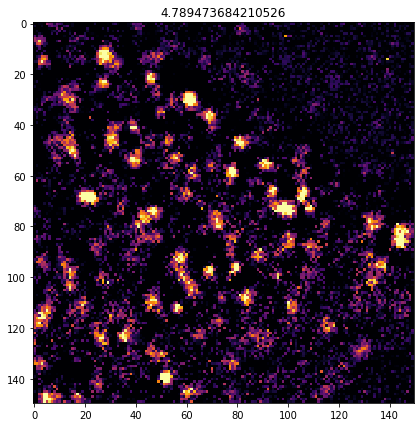

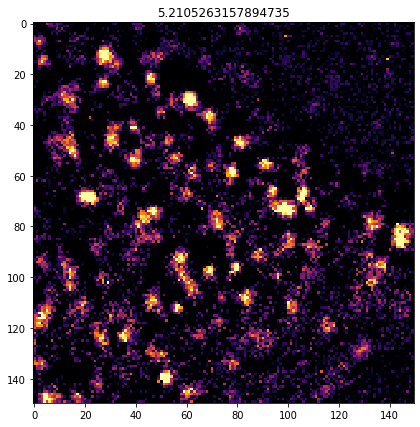

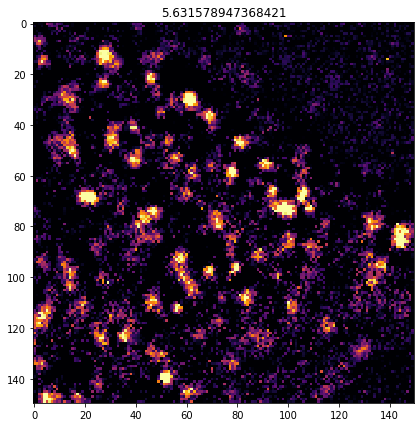

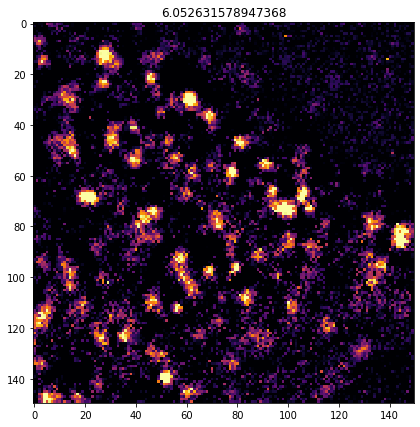

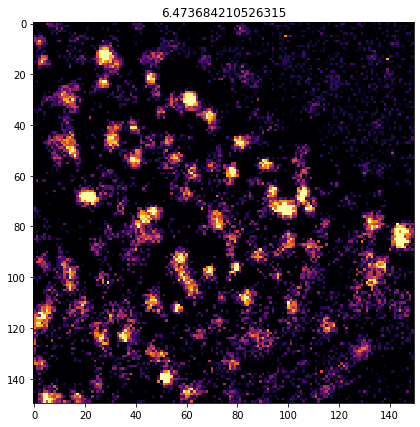

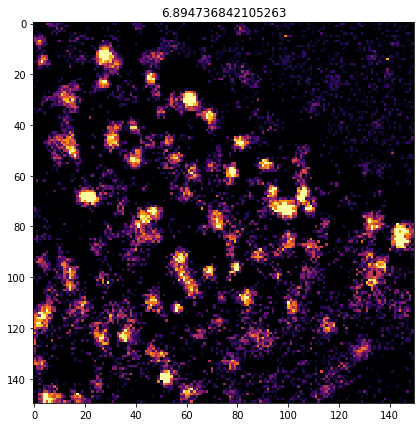

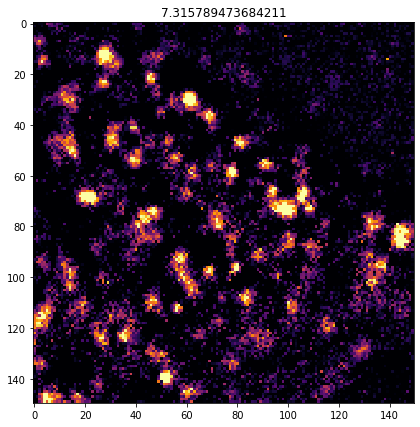

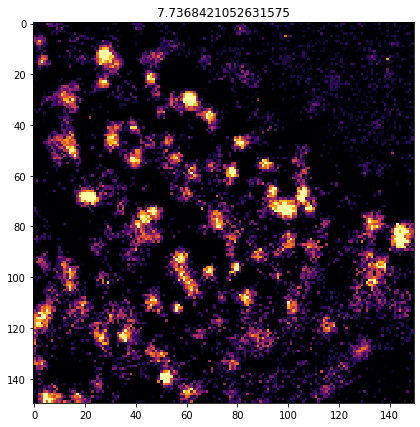

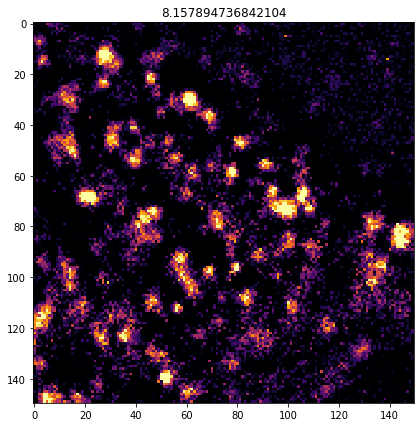

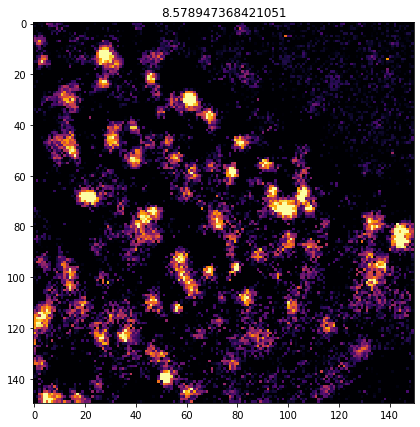

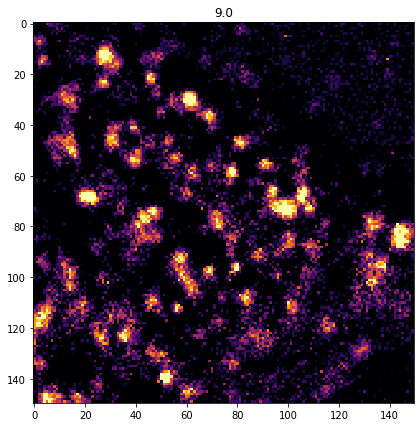

In [39]:
%matplotlib inline
for i in np.linspace(1,9,20):
    img_bg = gaussian(img, (i,i), preserve_range=True)
    img_gbs = img-img_bg
    numpy.place(img_gbs, img_gbs<0, 1./2**16)
    Display(img_gbs[600:750,600:750],title=i,figsize=[7,7])

In [11]:
def dogonvole(image, psf, kernel=(2.75, 2.75, 0.), blur=(0.9, 0.9, 0.), niter=10,):
    """
    Perform deconvolution and difference of gaussian processing.

    Parameters
    ----------
    image : ndarray
    psf : ndarray
    kernel : tuple
    blur : tuple
    niter : int

    Returns
    -------
    image : ndarray
        Processed image same shape as image input.
    """
    hot_pixels = pickle.load(open('/home/zach/PythonRepos/PySpots/hybescope_config/hot_pixels_oct2018.pkl','rb'))
    use_gpu=1
    gpu_algorithm = fd_restoration.RichardsonLucyDeconvolver(2).initialize()
    if not psf.sum() == 1.:
        raise ValueError("psf must be normalized so it sums to 1")
    image = image.astype('float32')
    imin = image.min()
    for y, x in hot_pixels:
        image[y, x] = imin;
        
    img_bg = gaussian(image, kernel[:len(image.shape)], preserve_range=True)
    image = numpy.subtract(image, img_bg)
    numpy.place(image, image<0, 1./2**16)
    image = image.astype('uint16')
    if len(image.shape)==3:
        for i in range(image.shape[2]):
            if use_gpu==1:
                image[:,:,i] = gpu_algorithm.run(fd_data.Acquisition(data=image[:,:,i], kernel=psf), niter=niter).data
            else:
                image[:,:,i] = restoration.richardson_lucy(image[:,:,i], psf,niter, clip=False)
    elif len(image.shape)==2:
        if use_gpu==1:
            image = gpu_algorithm.run(fd_data.Acquisition(data=image, kernel=psf), niter=niter).data
        else:
            image = restoration.richardson_lucy(image, psf, niter, clip=False)
    else:
        raise ValueError('image is not a supported dimensionality.')
    image = gaussian(image, blur[:len(image.shape)], preserve_range=True)
    return image

In [12]:
from hybescope_config.microscope_config import farred_psf

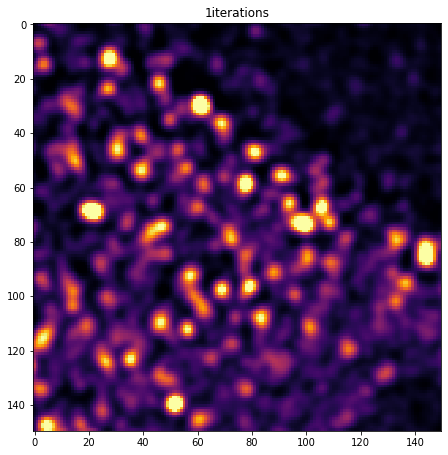

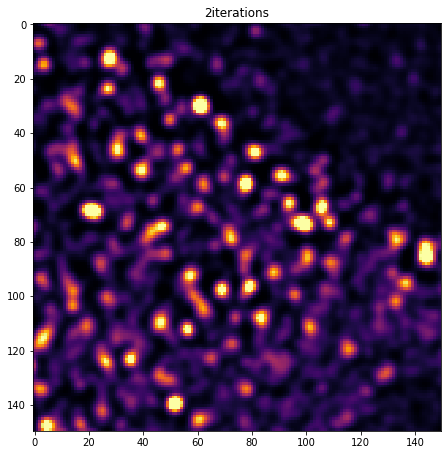

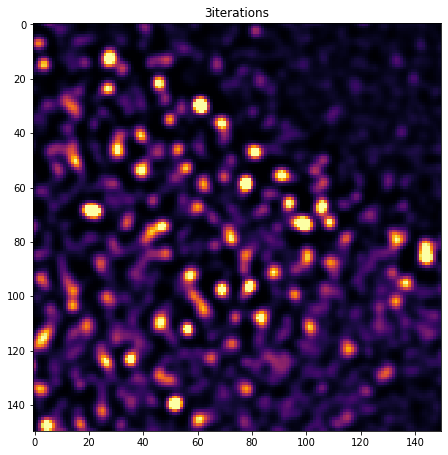

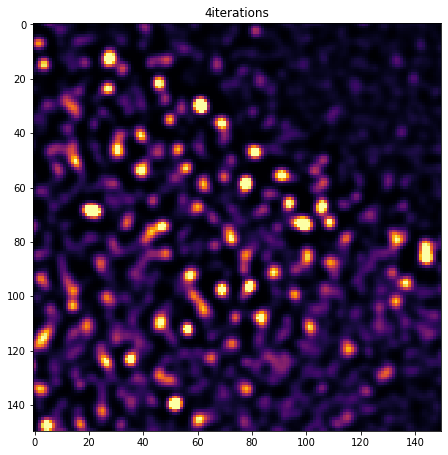

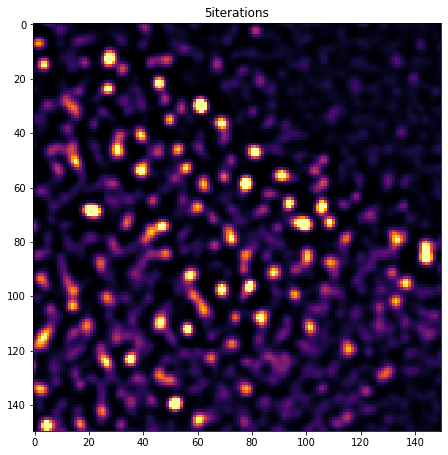

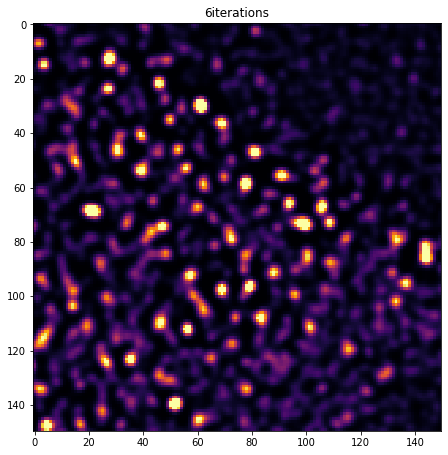

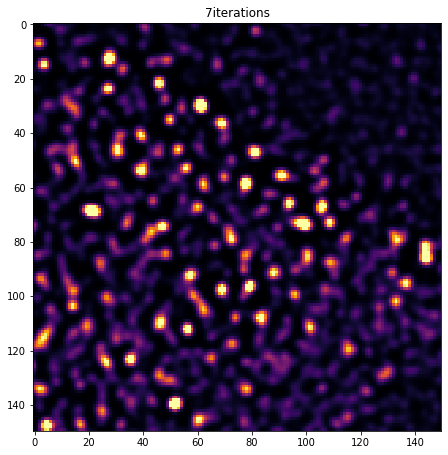

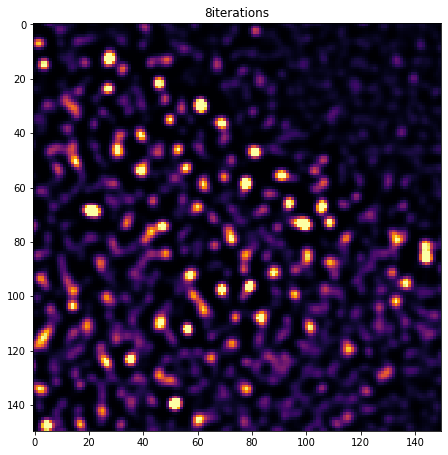

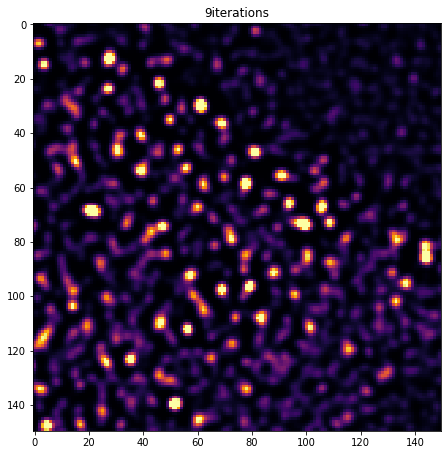

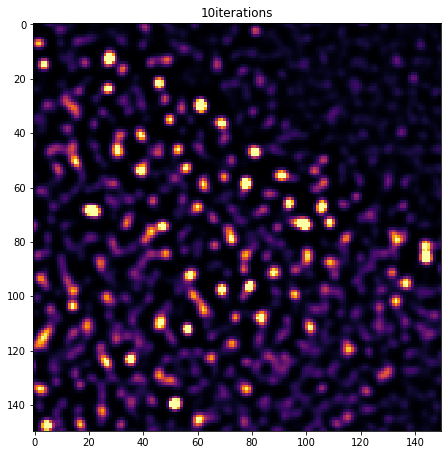

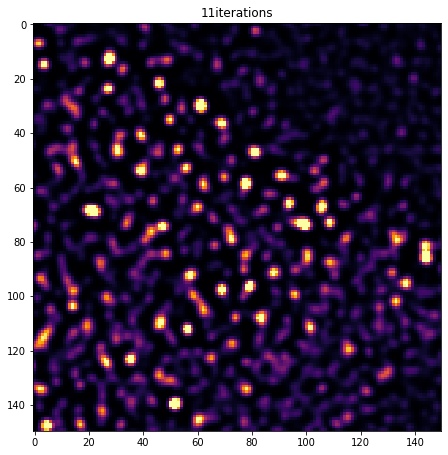

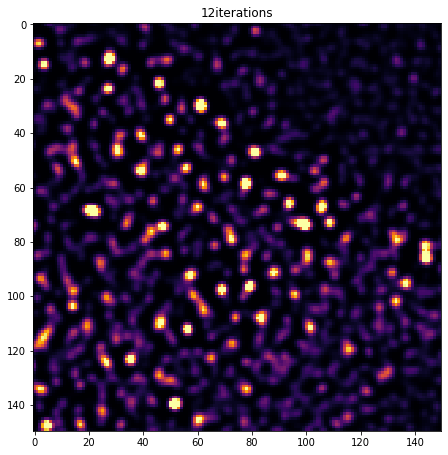

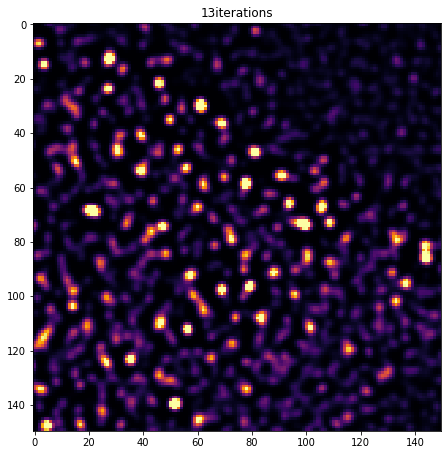

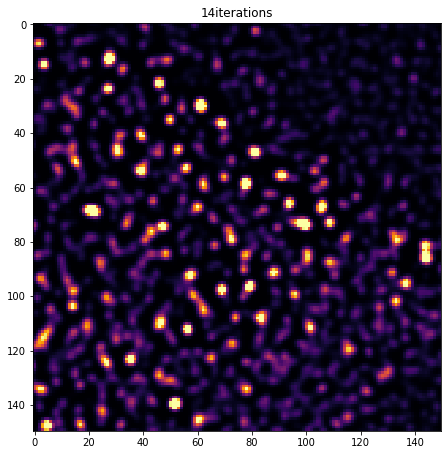

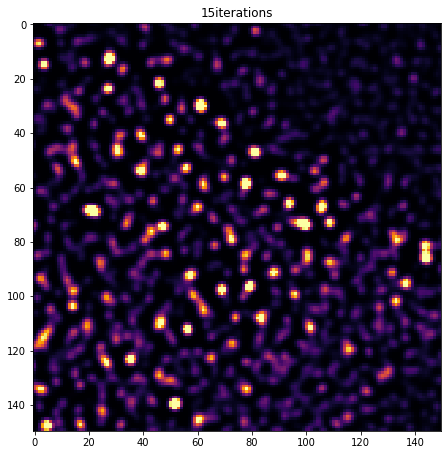

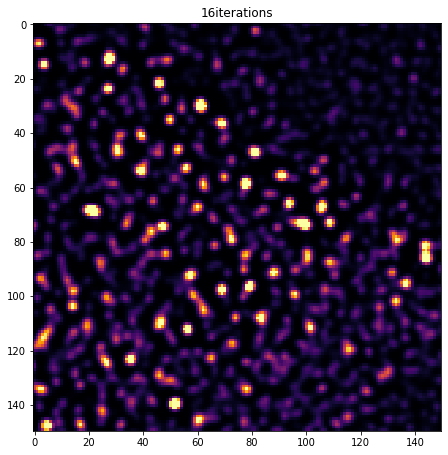

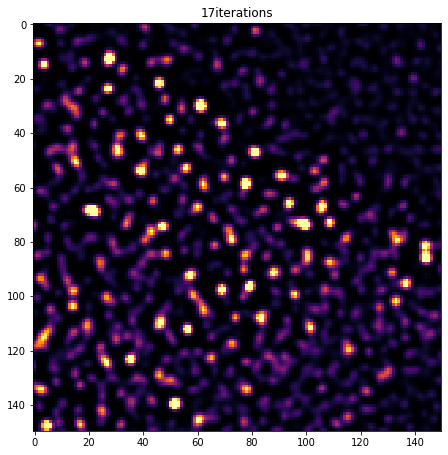

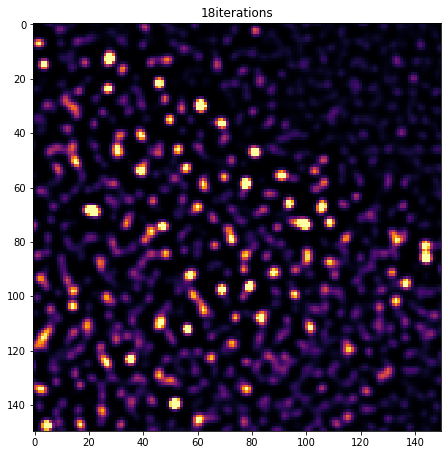

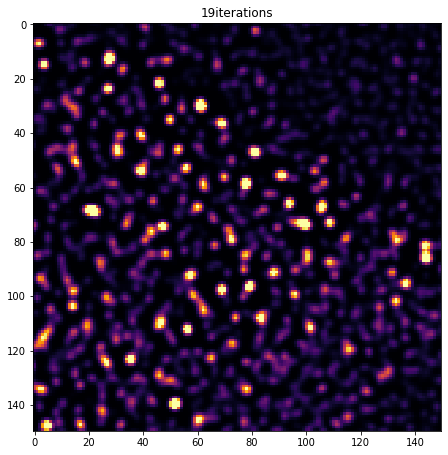

In [19]:
%matplotlib inline
for i in range(1,20):
    dimg = dogonvole(img, farred_psf, kernel=(2.5, 2.5, 0.), blur=(0.9, 0.9, 0.), niter=i)
    Display(dimg[600:750,600:750],figsize=[7.5,7.5],title=str(str(i)+'iterations'))
    

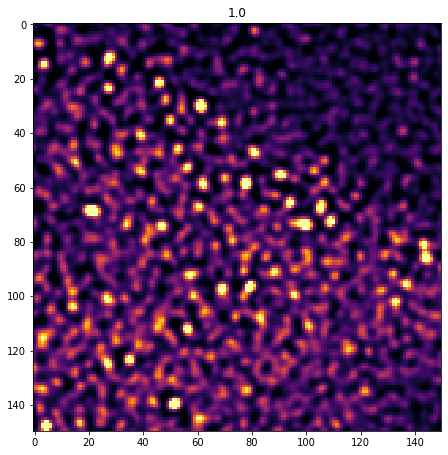

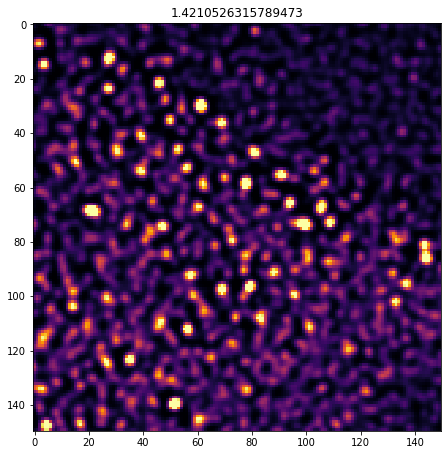

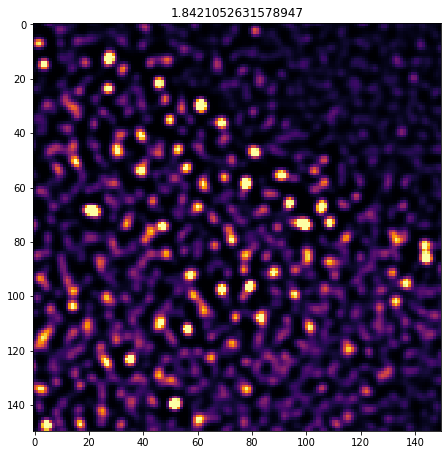

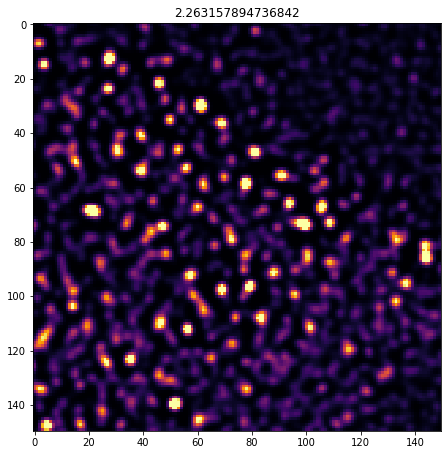

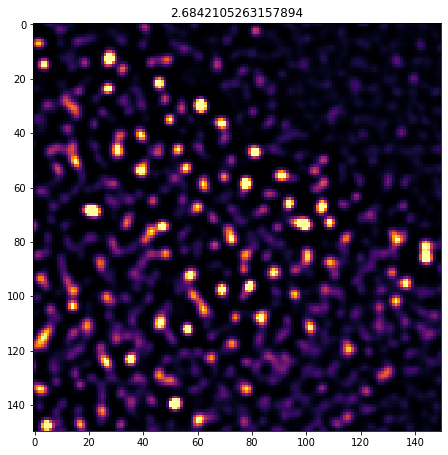

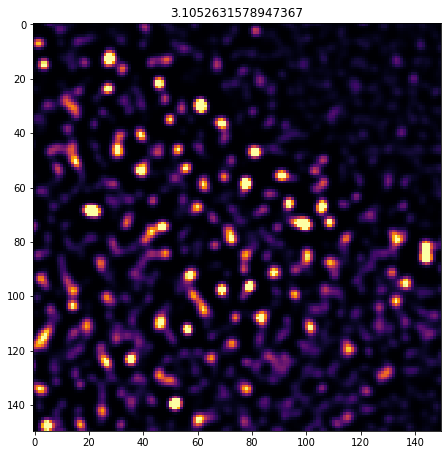

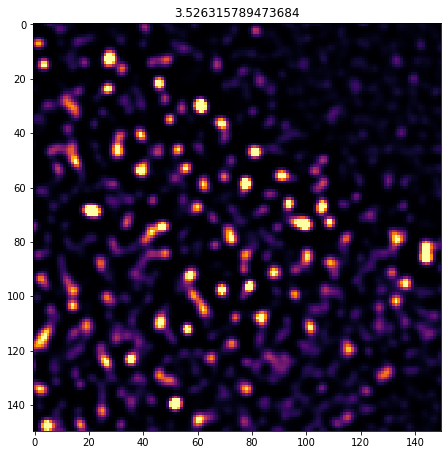

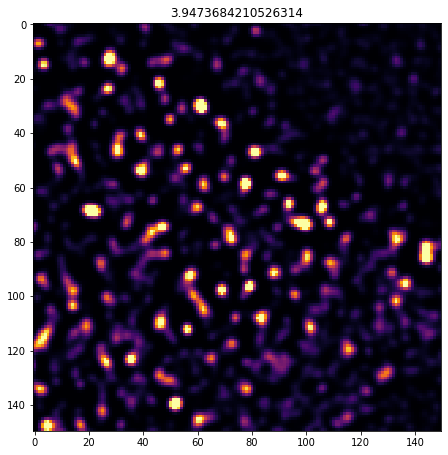

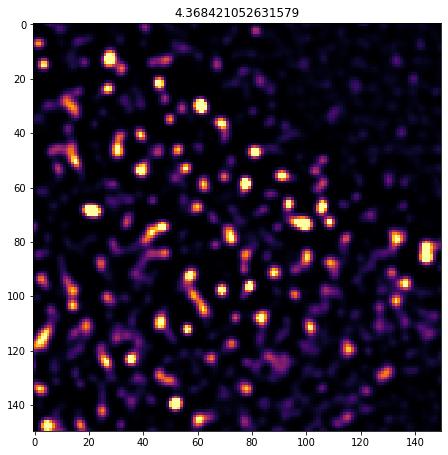

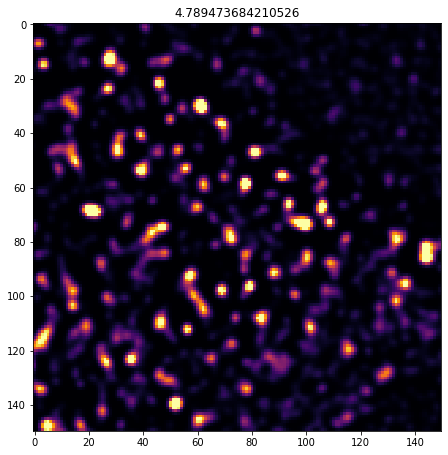

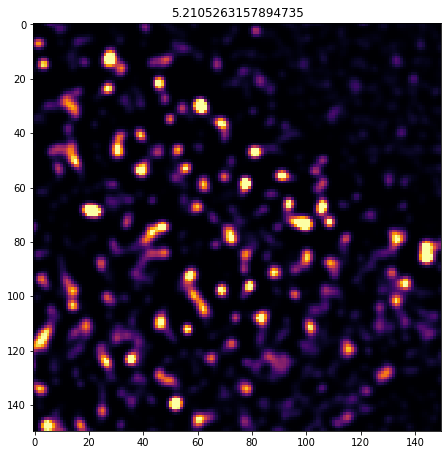

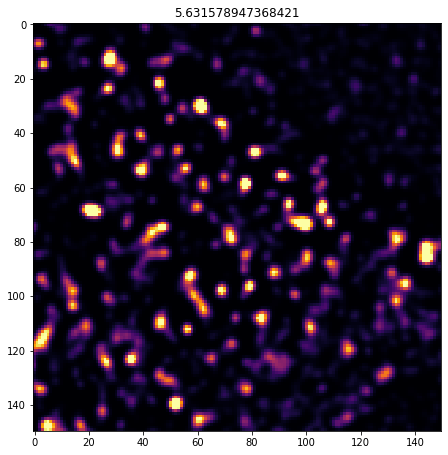

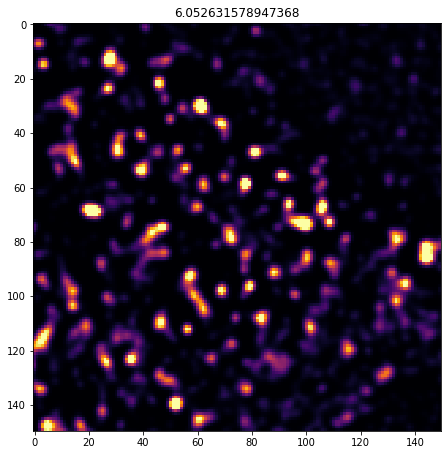

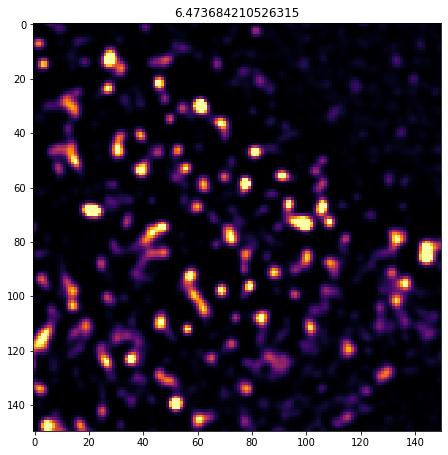

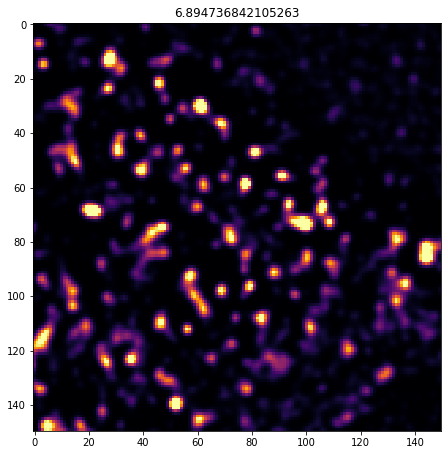

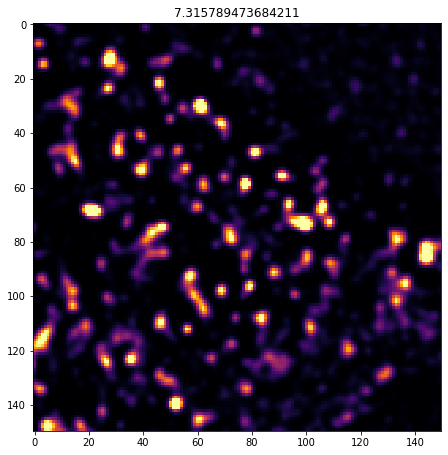

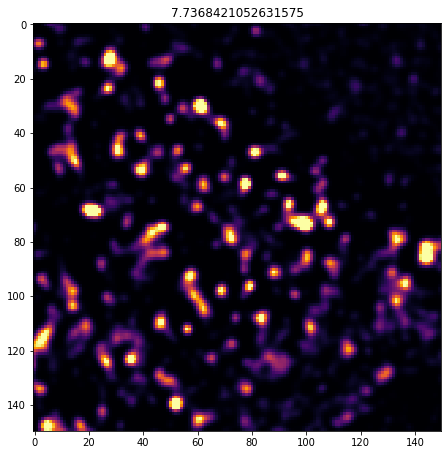

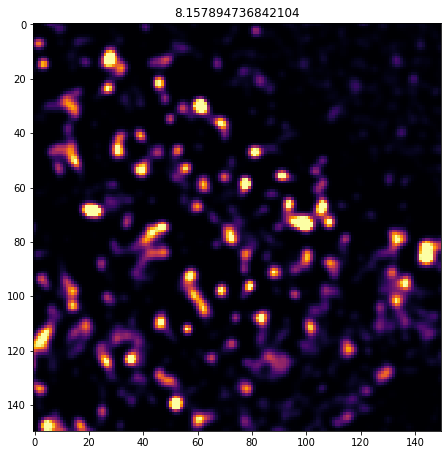

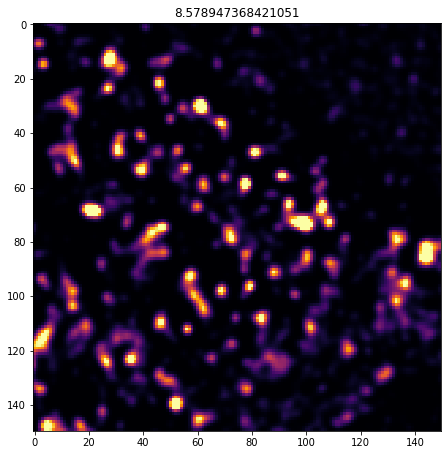

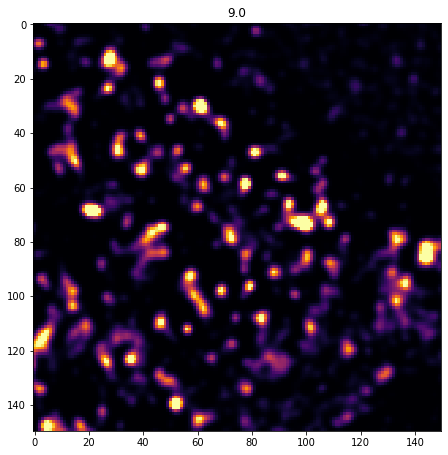

In [18]:
%matplotlib inline
for i in np.linspace(1,9,20):
    dimg = dogonvole(img, farred_psf, kernel=(i, i, 0.), blur=(0.9, 0.9, 0.), niter=10)
    Display(dimg[600:750,600:750],figsize=[7.5,7.5],title=str(str(i)+' sigma bkg'))
    

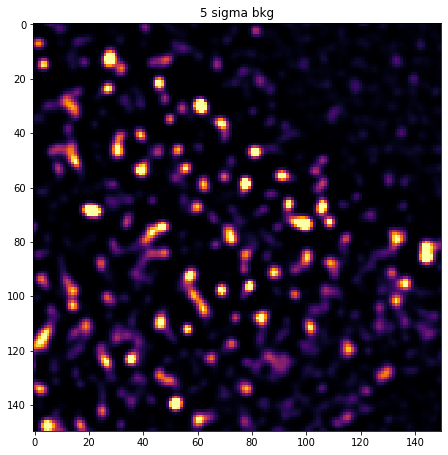

In [21]:
%matplotlib inline
dimg = dogonvole(img, farred_psf, kernel=(5, 5, 0.), blur=(0.9, 0.9, 0.), niter=10)
Display(dimg[600:750,600:750],figsize=[7.5,7.5],title=str(str(5)+' sigma bkg'))
    

<IPython.core.display.Javascript object>


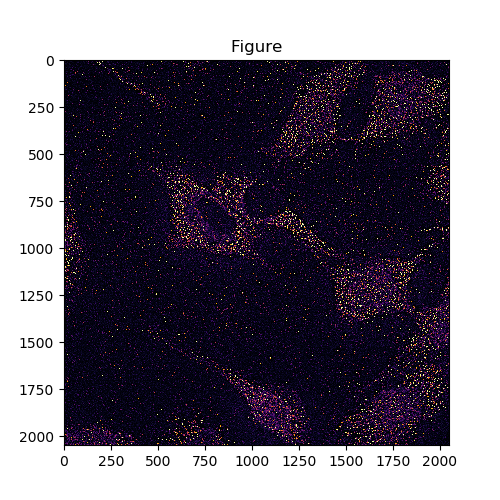

In [16]:
%matplotlib notebook
Display(dimg,figsize=[5,5])

In [ ]:
from analysis_scripts.onfly_decon_codestacks import *
def hdata_multi_z_pseudo_maxprjZ_wrapper(pos_hdata, posname, tforms_xy, tforms_z, md, reg_ref='hybe1', zstart=5, k=2, zskip=4, zmax=26, ndecon_iter = 10, nf_init_qtile=95,kernel=(2., 2., 0.), blur=(1.2, 1.2, 0.)):
    global image_size, bitmap, out_path, flatfield_dict
    NoneType = type(None)
    tforms_z = {k: int(np.round(np.mean(v))) for k, v in tforms_z.items()}
    tforms_z[reg_ref] = 0
    tforms_xy[reg_ref] = (0,0)
    seqs, hybes, channels = zip(*bitmap)
    psf_map = {'Orange': orange_psf, 'FarRed': farred_psf, 'Green': green_psf}
    hybes, channels = np.array(hybes), np.array(channels)
    completed_idx = np.array([i for i in range(len(hybes)) if hybes[i] in tforms_xy])
    if not os.path.exists(os.path.join(pos_hdata.base_path, 'processing.pkl')):
        completed_not_processed_idx = completed_idx
    else:
        doneso = pickle.load(open(os.path.join(pos_hdata.base_path, 'processing.pkl'), 'rb'))
        completed_not_processed_idx = np.array([i for i in completed_idx if i not in doneso])
    if len(completed_not_processed_idx) == 0:
        return 'Passed'

    print('\n','Imaging completed: ', completed_idx)
    pool = multiprocessing.Pool(18)
    for z_i in list(range(zstart, zmax, zskip)):
        try:
            cstk = pos_hdata.load_data(posname, z_i, 'cstk')
            if isinstance(cstk,NoneType):
                cstk = np.empty((image_size[0], image_size[1], len(bitmap)))
                completed_not_processed_idx = completed_idx
            else:
                completed_not_processed_idx = np.array([i for i in completed_idx if np.mean(cstk[:,:,i])==0])
            print('Imaging done but not processed: ', completed_not_processed_idx)
            if len(completed_not_processed_idx) == 0:
                continue
            codebits = []
            t_xys = []
            for bitmap_idx in completed_not_processed_idx:
                seq, hybe, chan = bitmap[bitmap_idx]
                t_z = tforms_z[hybe]
                t_xy = tforms_xy[hybe]
                t_xys.append(t_xy)
                cbit = md.stkread(Channel=chan, hybe=hybe, Position=posname, Zindex=list(range(z_i-t_z-k, z_i-t_z+k+1))).max(axis=2)
                cbit = dogonvole(cbit, psf_map[chan], niter=ndecon_iter)
                codebits.append(cbit)
            hnames= hybes[completed_not_processed_idx]
            channels_subset = channels[completed_not_processed_idx]
            nf = np.empty(len(bitmap))
            sys.stdout.flush()
            results = pool.starmap(pfunc_img_process, zip(codebits, channels_subset, hnames, t_xys))
            for bitmap_idx, cbit in zip(completed_not_processed_idx, results):
                cstk[:,:,bitmap_idx] = cbit
            nf = np.percentile(cstk, nf_init_qtile, axis=(0, 1))
            pos_hdata.add_and_save_data(cstk, posname, z_i, 'cstk')
            pos_hdata.add_and_save_data(nf, posname, z_i, 'nf')
            pos_hdata.add_and_save_data(np.zeros((cstk.shape[0], cstk.shape[1])), posname, z_i, 'cimg')
            
        except Exception as e:
            print(posname,z_i,'Failed')
            print(e)
    try:
        pickle.dump(set(completed_idx), open(os.path.join(pos_hdata.base_path, 'processing.pkl'), 'wb'))
    except:
        (posname,'Entire Position Failed')
    pool.close()
    sys.stdout.flush()
    return cstk,nf

In [ ]:
cstk,nf = hdata_multi_z_pseudo_maxprjZ_wrapper(pos_hdata, posname, tforms_xy, tforms_z, md, reg_ref='hybe1', zstart=5, k=2, zskip=4, zmax=26, ndecon_iter = 20, nf_init_qtile=95)
cimg = classify_codestack(cstk,mask, nfactor, nvectors, csphere_radius=csphere_radius,intensity=intensity)
df,new_nf = parse_classification_image(new_class_img, cstk, nvectors, genes, z)



In [3]:
seqfish_config = importlib.import_module('seqfish_config_Inflammation')
bitmap = seqfish_config.bitmap
from hybescope_config.microscope_config import *

In [4]:
psf = []
for bit in bitmap:
    color = bit[2]
    if color == 'FarRed':
        psf.append(farred_psf)
    elif color == 'Orange':
        psf.append(orange_psf)
    elif color == 'Green':
        psf.append(green_psf)
    else:
        print(color, ' is wrong')

In [5]:
def dogonvole(image, psf, kernel=(2.75, 2.75, 0.), blur=(0.9, 0.9, 0.), niter=10,):
    """
    Perform deconvolution and difference of gaussian processing.

    Parameters
    ----------
    image : ndarray
    psf : ndarray
    kernel : tuple
    blur : tuple
    niter : int

    Returns
    -------
    image : ndarray
        Processed image same shape as image input.
    """
    hot_pixels = pickle.load(open('/home/zach/PythonRepos/PySpots/hybescope_config/hot_pixels_oct2018.pkl','rb'))
    use_gpu=1
    gpu_algorithm = fd_restoration.RichardsonLucyDeconvolver(2).initialize()
    if not psf.sum() == 1.:
        raise ValueError("psf must be normalized so it sums to 1")
    image = image.astype('float32')
    imin = image.min()
    for y, x in hot_pixels:
        image[y, x] = imin;
        
    img_bg = gaussian(image, kernel[:len(image.shape)], preserve_range=True)
    image = numpy.subtract(image, img_bg)
    numpy.place(image, image<0, 1./2**16)
    image = image.astype('uint16')
    if len(image.shape)==3:
        for i in range(image.shape[2]):
            if use_gpu==1:
                image[:,:,i] = gpu_algorithm.run(fd_data.Acquisition(data=image[:,:,i], kernel=psf), niter=niter).data
            else:
                image[:,:,i] = restoration.richardson_lucy(image[:,:,i], psf,niter, clip=False)
    elif len(image.shape)==2:
        if use_gpu==1:
            image = gpu_algorithm.run(fd_data.Acquisition(data=image, kernel=psf), niter=niter).data
        else:
            image = restoration.richardson_lucy(image, psf, niter, clip=False)
    else:
        raise ValueError('image is not a supported dimensionality.')
    image = gaussian(image, blur[:len(image.shape)], preserve_range=True)
    return image

In [6]:
kernels = [2.,3.,4.,5.,6.,7.]
cstk_path = os.path.join(md_path,'codestacks_000')
for k in kernels:
    kernel_path = os.path.join(md_path,'codestacks_test',str('kernel'+str(k)))
    if not os.path.exists(kernel_path):
        os.makedirs(kernel_path)

for pos in os.listdir(cstk_path):
    print(pos)
    hdata = HybeData(os.path.join(cstk_path,pos))
    for z in hdata.metadata.zindex.unique():
        cstk = hdata.load_data(pos,z,'cstk')
        pos_path = os.path.join(md_path,'codestacks_test',str('kernel'+str(k)),pos)
        if not os.path.exists(pos_path):
            os.makedirs(pos_path)
        new_hdata = HybeData(pos_path)
        for k in kernels:
            pos_path = os.path.join(md_path,'codestacks_test',str('kernel'+str(k)),pos)
            if not os.path.exists(pos_path):
                os.makedirs(pos_path)
            new_hdata = HybeData(pos_path)
            new_cstk = cstk.copy()
            for i in range(cstk.shape[2]):
                new_cstk[:,:,i]=dogonvole(new_cstk[:,:,i], psf[i], kernel=(k,k,0), blur=(0.9, 0.9, 0.), niter=10)
            nf = np.percentile(new_cstk, 95, axis=(0, 1))
            new_hdata.add_and_save_data(nf,pos,z,'nf')
            new_hdata.add_and_save_data(new_cstk,pos,z,'cstk')
            new_hdata.add_and_save_data(np.zeros((new_cstk.shape[0], new_cstk.shape[1])), pos, z, 'cimg')


2-Pos_005_002


W0813 20:00:05.600284 139852545517376 deprecation_wrapper.py:119] From /home/zach/miniconda3/envs/pyspots_gpu/lib/python3.6/site-packages/flowdec/restoration.py:144: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0813 20:00:05.603685 139852545517376 deprecation_wrapper.py:119] From /home/zach/miniconda3/envs/pyspots_gpu/lib/python3.6/site-packages/flowdec/restoration.py:223: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0813 20:00:05.622139 139852545517376 deprecation_wrapper.py:119] From /home/zach/miniconda3/envs/pyspots_gpu/lib/python3.6/site-packages/flowdec/restoration.py:233: The name tf.assert_greater is deprecated. Please use tf.compat.v1.assert_greater instead.

W0813 20:00:05.645952 139852545517376 deprecation_wrapper.py:119] From /home/zach/miniconda3/envs/pyspots_gpu/lib/python3.6/site-packages/flowdec/restoration.py:243: The name tf.assert_greater_equal is deprecated. P

2-Pos_002_001
2-Pos_003_000
2-Pos_001_003
2-Pos_004_002
2-Pos_000_005
2-Pos_002_004
2-Pos_001_001
2-Pos_003_005


In [3]:
kernels = [2.,3.,4.,5.,6.,7.]
spotcalls_dict ={} 
for k in kernels:
    kernel_path = os.path.join(md_path,'codestacks_test',str('kernel'+str(k)))
    spotcalls_dict[str(k)] = pickle.load(open(os.path.join(kernel_path,'spotcalls.pkl'),'rb'))


In [4]:
for k,spotcalls in spotcalls_dict.items():
    print(k,' ',len(spotcalls))

2.0   4115918
3.0   5073128
4.0   5353730
5.0   5427762
6.0   5435476
7.0   5418382


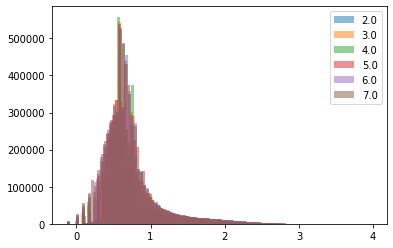

In [10]:
%matplotlib inline
for k,spotcalls in spotcalls_dict.items():
    plt.hist(np.log10(spotcalls.ave),bins=100,label=k,alpha=0.5)
plt.legend()
plt.show()



In [5]:
f = '/bigstore/GeneralStorage/Evan/NFKB_MERFISH/Calibration_Set_Data/3T3_Calibration_Set/RNA_Seq_Data/Hoffmann_IFNAR_KO_3T3_TNF.txt'
ReadsPerGene = pd.read_csv(f,sep='\t')

In [24]:
ReadsPerGene.index = [i.split('.')[0] for i in ReadsPerGene.Geneid]

In [25]:
ReadsPerGene

Geneid                  Chr  \
ENSMUSG00000102693  ENSMUSG00000102693.1                 chr1   
ENSMUSG00000064842  ENSMUSG00000064842.1                 chr1   
ENSMUSG00000051951  ENSMUSG00000051951.5  chr1;chr1;chr1;chr1   
ENSMUSG00000102851  ENSMUSG00000102851.1                 chr1   
ENSMUSG00000103377  ENSMUSG00000103377.1                 chr1   
...                                  ...                  ...   
ENSMUSG00000064368  ENSMUSG00000064368.1                 chrM   
ENSMUSG00000064369  ENSMUSG00000064369.1                 chrM   
ENSMUSG00000064370  ENSMUSG00000064370.1                 chrM   
ENSMUSG00000064371  ENSMUSG00000064371.1                 chrM   
ENSMUSG00000064372  ENSMUSG00000064372.1                 chrM   

                                              Start  \
ENSMUSG00000102693                          3073253   
ENSMUSG00000064842                          3102016   
ENSMUSG00000051951  3205901;3213439;3421702;3670552   
ENSMUSG00000102851                          3252757   
ENSMUSG00000103377                          3365731   
...                                             ...   
ENSMUSG00000064368                            13552   
ENSMUSG00000064369                            14071   
ENSMUSG00000064370                            14145   
ENSMUSG00000064371                            15289   
ENSMUSG00000064372                            15356   

                                                End   Strand  Length  \
ENSMUSG00000102693                          3074322        +    1070   
ENSMUSG00000064842                          3102125        +     110   
ENSMUSG00000051951  3207317;3216968;3421901;3671498  -;-;-;-    6094   
ENSMUSG00000102851                          3253236        +     480   
ENSMUSG00000103377                          3368549        -    2819   
...                                             ...      ...     ...   
ENSMUSG00000064368                            14070        -     519   
ENSMUSG00000064369                            14139        -      69   
ENSMUSG00000064370                            15288        +    1144   
ENSMUSG00000064371                            15355        +      67   
ENSMUSG00000064372                            15422        -      67   

                    IFNAR-0_tot.bam  IFNAR-IL1-05_tot.bam  \
ENSMUSG00000102693                0                     0   
ENSMUSG00000064842                0                     0   
ENSMUSG00000051951                5                     2   
ENSMUSG00000102851                0                     0   
ENSMUSG00000103377                0                     0   
...                             ...                   ...   
ENSMUSG00000064368              197                   854   
ENSMUSG00000064369                0                     3   
ENSMUSG00000064370            56248                 65585   
ENSMUSG00000064371                5                     8   
ENSMUSG00000064372                0                     6   

                    IFNAR-IL1-1_tot.bam  IFNAR-IL1-24_tot.bam  ...  \
ENSMUSG00000102693                    0                     0  ...   
ENSMUSG00000064842                    0                     0  ...   
ENSMUSG00000051951                    6                     9  ...   
ENSMUSG00000102851                    0                     0  ...   
ENSMUSG00000103377                    1                     0  ...   
...                                 ...                   ...  ...   
ENSMUSG00000064368                  443                   550  ...   
ENSMUSG00000064369                    1                     2  ...   
ENSMUSG00000064370                70558                 61762  ...   
ENSMUSG00000064371                    5                     5  ...   
ENSMUSG00000064372                    4                     5  ...   

                    IFNAR-NFKBIA-TNF-3_tot.bam  IFNAR-NFKBIA-TNF-5_tot.bam  \
ENSMUSG00000102693                           0                           0 

In [52]:
def merfish_correlation(spotcalls,color='b',alpha=1,label='spotcalls',system='cornea',ReadsPerGene=False):
    import pandas as pd
    if not isinstance(ReadsPerGene,pd.core.frame.DataFrame):
        if system=='cornea':
            f = '/bigstore/GeneralStorage/Zach/Cornea_RNAseq/Aligned/ReadsPerGene.xlsx'
            ReadsPerGene = pd.read_excel(f)
            ReadsPerGene.index = ReadsPerGene.GeneIDs
        elif system=='3t3':
            f = '/bigstore/GeneralStorage/Evan/NFKB_MERFISH/Calibration_Set_Data/3T3_Calibration_Set/RNA_Seq_Data/Hoffmann_IFNAR_KO_3T3_TNF.txt'
            ReadsPerGene = pd.read_csv(f,sep='\t')
            gids = []
            for gid in ReadsPerGene.Geneid:
                gids.append(gid.split('.')[0])
            ReadsPerGene.Geneid = gids
            ReadsPerGene.index = gids
        else:
            print('Unknown System')
    GeneList = pd.read_csv('/bigstore/GeneralStorage/Zach/MERFISH/Inflammatory/InflammationGeneList.csv')
    GeneList.index = GeneList.Gene
    counts = []
    fpkms = []
    from collections import defaultdict, Counter
    FISH_Spots = Counter(spotcalls.gene)
    for gn,cc in FISH_Spots.items():
        if 'blank' in gn:
            continue
        else:
            gid = GeneList.loc[gn]['Gene_ID']
            if system=='cornea':
                reads = ReadsPerGene.loc[gid].Unstranded
            elif system=='3t3':
                reads = ReadsPerGene.loc[gid]['IFNAR-TNF-1_tot.bam']
            else:
                print('Unknown System')
            fpkm = reads/GeneList.loc[gn]['Length']
            if isinstance(fpkm,np.float64):
                if cc<2:
                    continue
                counts.append(cc)
                fpkms.append(fpkm)
    from scipy.stats import spearmanr
    import matplotlib.pyplot as plt
    plt.scatter(np.log10(fpkms),np.log10(counts),alpha=alpha,label=label)
    print(label,':',spearmanr(fpkms,counts))
    plt.suptitle('Untrimmed FPKM vs Spot Count')
    plt.ylabel('log10 MERFISH Spot Count')
    plt.xlabel('log10 RNAseq FPKM')
    plt.legend()

/home/zach/miniconda3/envs/pyspots_gpu/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log10


2.0 : SpearmanrResult(correlation=0.02551676427657135, pvalue=0.7404318217253483)
3.0 : SpearmanrResult(correlation=0.016653506740410218, pvalue=0.8288392079536198)
4.0 : SpearmanrResult(correlation=0.009746351268259448, pvalue=0.8993216780548339)
5.0 : SpearmanrResult(correlation=0.013527532362360104, pvalue=0.8606034821522004)
6.0 : SpearmanrResult(correlation=0.013979938488280717, pvalue=0.8559912794240475)
7.0 : SpearmanrResult(correlation=0.012940750825149195, pvalue=0.8665926232943434)


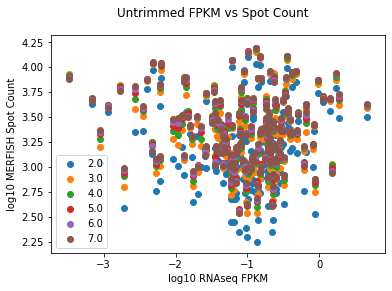

In [54]:
%matplotlib inline

for k,spotcalls in spotcalls_dict.items():
    merfish_correlation(spotcalls[spotcalls.ave>10**1.1],alpha=1,label=str(k),system='3t3',ReadsPerGene=ReadsPerGene)
plt.legend()
plt.show()